# Final project: Finding the suspect

<a href="https://en.wikipedia.org/wiki/Facial_composite.">Facial composits</a> are widely used in forensics to generate images of suspects. Since victim or witness usually isn't good at drawing, computer-aided generation is applied to reconstruct the face attacker. One of the most commonly used techniques are evolutionary systems that compose the final face from many predefined parts.

In this project we will try to implement an app for crating facial composite that will be able to construct desired faces without explicitly providing databases of templates. We will apply Variational Autoencoders and Gaussian processes for this task.

Final project is developed in a way that you can apply learned techniques to real project yourself. We will include main guidelines and hints, but great part of the project will need your creativity and experience from previous assignments.

### Installation

We will need ```tensorflow```, ```keras```, ```GPy```, ```GPyOpt```, ```h5py``` libraries for this assignment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
import GPy
import GPyOpt
import keras
from keras.layers import Input, Dense, Lambda, InputLayer, concatenate, Activation, Flatten, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Deconv2D
from keras.losses import MSE
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
import utils
import os
%matplotlib inline

C:\Users\Paul\Anaconda3\envs\BMML\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Grading
As some of the final project tasks can be graded only visually, final assignment is graded using peer-review procedure. You will be asked to upload your Jupyter notebook on the web and attach link to it in the submission form. Detailed submission instructions and grading criterions are written in the end of this notebook.

## Model description
We will first train variational autoencoder on face images to compress them to low dimension. One important feature of VAE is that constructed latent space is in some sence continous. That means, that we can safely move along the space and any point along our path will be reconstructed into a valid face.

Using this continuous latent space we can use bayesian optimization to maximise some similarity function between person's face in victim/witness's memory and a face reconstructed from current point of latent space. Bayesian optimization is an appropriate choice here, since people start to forget detales about the attacker after they were shown many similar photos. Because of this, we want to reconstruct the photo with the smallest possible number of trials.

## Generating faces

For this task you will need to use some database of face images. There are multiple datasets available on the web that you can use: for example, <a href="http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html">CelebA</a> or <a href="http://vis-www.cs.umass.edu/lfw/">Labeled Faces in the Wild</a>. We used Alligned & Cropped version of CelebA that you can find <a href="https://www.dropbox.com/sh/8oqt9vytwxb3s4r/AADSNUu0bseoCKuxuI5ZeTl1a/Img?dl=0&preview=img_align_celeba.zip">here</a> to pretrain VAE model for you. See optional part of final project if you whish to train VAE on your own.

<b>Task 1:</b> Train VAE on faces dataset and draw some samples from it. (You can use code from previous assignmnets. You may also want to use convolutional encoders and decoders as well as tuning hyperparameters)

In [2]:
sess = tf.InteractiveSession()
K.set_session(sess)

In [3]:
latent_size = 8

In [4]:
vae, encoder, decoder = utils.create_vae(batch_size=128, latent=latent_size)
sess.run(tf.global_variables_initializer())
vae.load_weights('CelebA_VAE_small_8.h5')

In [5]:
K.set_learning_phase(False)

In [6]:
latent_placeholder = tf.placeholder(tf.float32, (1, latent_size))
decode = decoder(latent_placeholder)

#### GRADED 1 (3 points): Draw 25 samples from trained VAE model
As first part of assignment, you need to become familiar with trained model. For all tasks you will only need a decoder to reconstruct samples froma a latent space.

To decode latent variable, you need to run ```decode``` operation defined above with random samples from standard normal distribution.

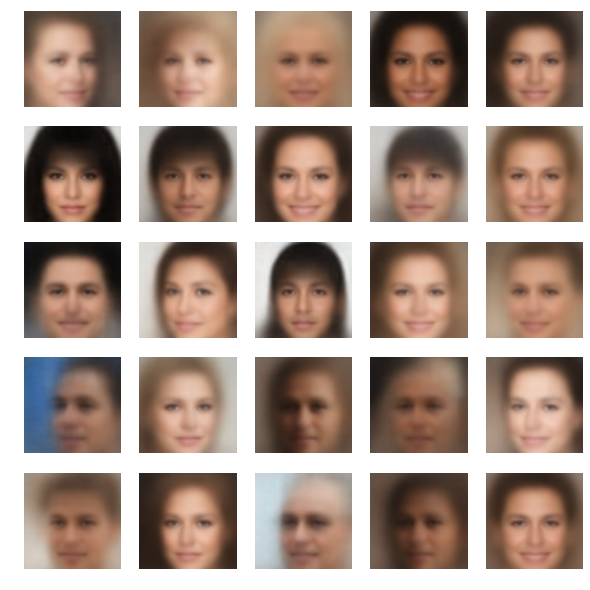

In [7]:
### TODO: Draw 25 samples from VAE here
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    image = decode.eval(feed_dict = {latent_placeholder : np.random.normal(size = (1, latent_size))}).squeeze()
    plt.imshow(np.clip(image, 0, 1))
    plt.axis('off')

## Search procedure

Now that we have a way to reconstruct images, we need to set up an optimization procedure to find a person that will be the most similar to the one we are thinking about. To do so, we need to set up some scoring utility. Imagine that you want to generate an image of Brad Pitt. You start with a small number of random samples, say 5, and rank them according their similarity to your vision of Brad Pitt: 1 for the worst, 5 for the best. You then rate image by image using GPyOpt that works in a latent space of VAE. For the new image you need to somehow assign a real number that will show how good this image is. The simple idea is to ask a user to compare a new image with previous images (along with their scores). User then enters score to a current image.

The proposed scoring has a lot of drawbacks, and you may feel free to come up with new ones: e.g. showing user 9 different images and asking a user which image looks the "best".

Note that the goal of this task is for you to implement a new algorithm by yourself. You may try different techniques for your task and select one that works the best.

<b>Task 2:</b> Implement person search using Bayesian optimization. (You can use code from the assignment on Gaussian Processes)

Note: try varying ```acquisition_type``` and ```acquisition_par``` parameters.

In [30]:
class FacialComposit:
    def __init__(self, decoder, latent_size):
        self.latent_size = latent_size
        self.latent_placeholder = tf.placeholder(tf.float32, (1, latent_size))
        self.decode = decoder(self.latent_placeholder)
        self.samples = None
        self.images = None
        self.rating = None

    def _get_image(self, latent):
        img = sess.run(self.decode, 
                       feed_dict={self.latent_placeholder: latent[None, :]})[0]
        img = np.clip(img, 0, 1)
        return img

    @staticmethod
    def _show_images(images, titles):
        assert len(images) == len(titles)
        clear_output()
        plt.figure(figsize=(3*len(images), 3))
        n = len(titles)
        for i in range(n):
            plt.subplot(n // 5 + 1, 5, i+1)
            plt.imshow(images[i])
            plt.title(str(titles[i]))
            plt.axis('off')
        plt.show()

    @staticmethod
    def _draw_border(image, w=2):
        bordred_image = image.copy()
        bordred_image[:, :w] = [1, 0, 0]
        bordred_image[:, -w:] = [1, 0, 0]
        bordred_image[:w, :] = [1, 0, 0]
        bordred_image[-w:, :] = [1, 0, 0]
        return bordred_image

    def query_initial(self, n_start=5, select_top=5):
        '''
        Creates initial points for Bayesian optimization
        Generate *n_start* random images and asks user to rank them.
        Gives maximum score to the best image and minimum to the worst.
        :param n_start: number of images to rank initialy.
        :param select_top: number of images to keep
        '''
        self.samples = np.random.normal(size=(n_start, self.latent_size)) ### YOUR CODE HERE (size: select_top x 64 x 64 x 3)
        self.images = np.zeros(shape = (n_start, 64, 64, 3)) ### YOUR CODE HERE (size: select_top x 64 x 64 x 3)
        self.rating = np.zeros(shape = (n_start)) ### YOUR CODE HERE (size: select_top)
        
        ### YOUR CODE:
        ### Show user some samples (hint: use self._get_image and input())
        
        # Create and display images
        for it in range(n_start):
            self.images[it, :, :, :] = self._draw_border(self._get_image(self.samples[it, :]))
        self._show_images(self.images, range(n_start))
        
        # Ask user for ratings
        for it in range(n_start):
            print('Please enter rating for image ', str(it), ' between 0 and 100 ')
            self.rating[it] = float(input())
            assert(self.rating[it] <= 100 and self.rating[it] >= 0), 'Number should be between 0 and 100'
            
        # Only take the select_top best images
        indices = np.argsort(self.rating, axis=-1, kind='quicksort')[n_start-select_top:]
        self.samples = self.samples[indices, :]
        self.images = self.images[indices, :, :, :]
        self.rating = self.rating[indices]

        # Check that tensor sizes are correct
        np.testing.assert_equal(self.rating.shape, [select_top])
        np.testing.assert_equal(self.images.shape, [select_top, 64, 64, 3])
        np.testing.assert_equal(self.samples.shape, [select_top, self.latent_size])

    def evaluate(self, candidate):
        '''
        Queries candidate vs known image set.
        Adds candidate into images pool.
        :param candidate: latent vector of size 1xlatent_size
        '''
        initial_size = len(self.images)
        
        ### YOUR CODE HERE
        ## Show user an image and ask to assign score to it.
        ## You may want to show some images to user along with their scores
        ## You should also save candidate, corresponding image and rating
        
        # TODO: show user some other images as examples
        # TODO: don't append, preallocate
        self.samples = np.append(self.samples, candidate, axis=0)
        img = self._get_image(candidate.reshape((self.latent_size)))
        self.images = np.append(self.images, img[None, :], axis=0)
        titles = ['Rating' + str(rate) for rate in self.rating] 
        titles.append('?')
        self._show_images(self.images, titles)
        
        print('Please enter rating for image ', titles[-1], ' between 0 and 100 ')
        
        candidate_rating = float(input())
        self.rating = np.append(self.rating, candidate_rating)
        
        assert len(self.images) == initial_size + 1
        assert len(self.rating) == initial_size + 1
        assert len(self.samples) == initial_size + 1
        return candidate_rating

    def optimize(self, n_iter=10, w=4, acquisition_type='MPI', acquisition_par=0.3):
        if self.samples is None:
            self.query_initial()

        bounds = [{'name': 'z_{0:03d}'.format(i),
                   'type': 'continuous',
                   'domain': (-w, w)} 
                  for i in range(self.latent_size)]
        optimizer = GPyOpt.methods.BayesianOptimization(f=self.evaluate, domain=bounds,
                                                        acquisition_type = acquisition_type,
                                                        acquisition_par = acquisition_par,
                                                        exact_eval=False, # Since we are not sure
                                                        model_type='GP',
                                                        X=self.samples,
                                                        Y=self.rating[:, None],
                                                        maximize=True)
        optimizer.run_optimization(max_iter=n_iter, eps=-1)

    def get_best(self):
        index_best = np.argmax(self.rating)
        return self.images[index_best]

    def draw_best(self, title=''):
        index_best = np.argmax(self.rating)
        image = self.images[index_best]
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
        plt.show()

#### GRADED 2 (3 points):
Describe your approach below: How do you assign score to a new image? How do you select reference images to help user assign a new score? What are the limitations of your approach?

> Your answer here

## Testing your algorithm

In the these sections we will apply implemented app to search of different people. Each task will ask you to generate images that will have some property like "dark hair" or "moustache". You will need to run your search algorithm and provide best found image.

#### Task 3.1: Finding person with darkest hair (3 points)

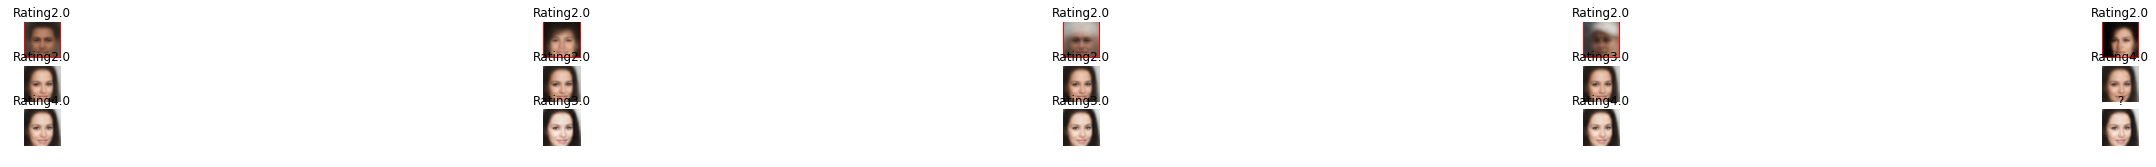

Please enter rating for image  ?  between 0 and 100 
3


In [31]:
composit = FacialComposit(decoder, 8)
composit.optimize()

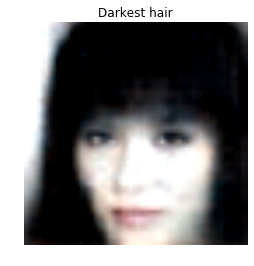

In [12]:
composit.draw_best('Darkest hair')

#### Task 3.2. Finding person with the widest smile (3 points)

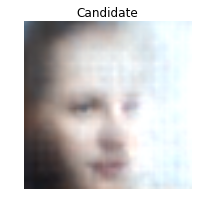

Please enter rating for image between 0 and 10 
1


In [90]:
composit = FacialComposit(decoder, 8)
composit.optimize()

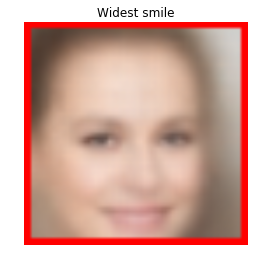

In [91]:
composit.draw_best('Widest smile')

#### Task 3.3. Finding Daniil Polykovskiy or Alexander Novikov — lecturers of this course (3 points) 

Note: this task highly depends on a quality of VAE and search algorithm. You may need to restart your search algorithm a few times and start with larget initial set.

In [ ]:
composit = FacialComposit(decoder, 8)
composit.optimize()

In [ ]:
composit.draw_best('Lecturer')

#### <small>Don't forget to post resulting image of lecturers on the forum ;)</small>

#### Task 3.4. Finding specific person (optional, but very cool)

Now that you have a good sence of what your algorithm can do, here is an optional assignment for you. Think of a famous person and take look at his/her picture for a minute. Then use your app to create an image of the person you thought of. You can post it in the forum <a href="https://www.coursera.org/learn/bayesian-methods-in-machine-learning/discussions/forums/SE06u3rLEeeh0gq4yYKIVA">Final project: guess who!</a>


In [ ]:
### Your code here

### Submission
You should submit an HTML version of your work. To convert your notebook to HTML, press file $\rightarrow$ download as $\rightarrow$  HTML (.html). Make sure that resulting html file can be opened when copied to a separate folder (that all of the images are present). You should attach only your html file to the peer review console.

### Grading criterions

#### Task 1 (3 points) [samples from VAE]
* 0 points: No results were provided here or provided images were not generated by VAE
* 1 point: Provided images poorly resemble faces
* 2 points: Provided images look like faces, maybe with some artifacts, but all look the same
* 3 points: Provided images look like faces, maybe with some artifacts, and look different

#### Task 2 (3 points) [training procedure]
* 0 points: No result was provided
* 1 point: Some algorithm was proposed, but it does not use Bayesian optimization
* 2 points: Algorithm was proposed, but there were no details on some important aspects: how to assign a score to a new image / how to you select a new image / what are the limitations of the approach
* 3 points: Algorithm was proposed, all questions in the task were answered

#### Tasks 3.1-3.3 (3 points each) [search for person]
* 0 points: Nothing was provided
* 1 point: Resulting image was provided, but some of the required images (evolution & nearest image) are not provided
* 2 points: All images are provided, but resulting image does not have requested property
* 3 points: All images are provided, resulting image has required features (long hair / wide smile / looks like lecturer)

## Passing grade is 60% (9 points)